## Ensure that we are running a GPU

In [ ]:
# Are we using a GPU?
!pip install --upgrade nvidia-pyindex
!sudo apt install nvidia-utils-515
!nvidia-smi

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8417 sha256=1510f2f5e3e0c15fe2a874545f6b06e6d99034db9992edb6e7e2e172502fa5ff
  Stored in directory: /root/.cache/pip/wheels/2c/af/d0/7a12f82cab69f65d51107f48bcd6179e29b9a69a90546332b3
Successfully built nvidia-pyindex
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libnvidia-compute-515
Suggested packages:
  nvidia-driver-515
The following NEW packages will be installed:
  libnvidia-compute-515 nvidia-utils-515
0 upgraded, 2 newly installed, 0 to remove and 17 not upgraded.
Need to get 45.4 MB of archives.
After this operation, 194 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libnvidia-compute-515 515.105.01-0ubuntu1 [45.0 MB]
Get:2 https://developer.download.nvidia.com/compute/c

## Load the Food Data Set

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-09-16 15:51:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 108.177.111.207, 142.250.1.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   154MB/s    in 1.0s    

2023-09-16 15:51:45 (154 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## Inspect the Data Set

In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Prepare the Data using ImageDataGenerator

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Create Callbacks Needed During Model Fitting

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

> 🔑 **Note:** Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.



## Create the Model

### Notes on Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

1. Go to [tfhub.dev](https://tfhub.dev/).
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on.
  * **Note:** "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.

> 🤔 **Question:** *I see many options for image classification models, how do I know which is best?*

You can see a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [models which perform best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet).

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear.
  * The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
    * However, the tradeoff with larger numbers can mean they take longer to compute.
7. Select EfficientNetB0 and you should see [something like the following](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.
  * Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

> 🤔 **Question:** *I thought we were doing image classification, why do we choose feature vector and not classification?*

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**.

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

> 🤔 **Question:** *Why train only the top 2-3 layers in feature extraction?*

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).*

Okay, enough talk, let's see this in action. Once we do, we'll explain what's happening.

First we'll import TensorFlow and TensorFlow Hub.

### Importing Models from Tensorflow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230916-155205
Epoch 1/5
24/24 [==============================] - 24s 470ms/step - loss: 1.8430 - accuracy: 0.3920 - val_loss: 1.1707 - val_accuracy: 0.6316
Epoch 2/5
24/24 [==============================] - 10s 413ms/step - loss: 0.8741 - accuracy: 0.7413 - val_loss: 0.8705 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.5944 - accuracy: 0.8387 - val_loss: 0.7650 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 10s 424ms/step - loss: 0.4511 - accuracy: 0.8827 - val_loss: 0.7183 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 9s 394ms/step - loss: 0.3692 - accuracy: 0.9147 - val_loss: 0.7001 - val_accuracy: 0.7736


Analyze the Model and It's Performance

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

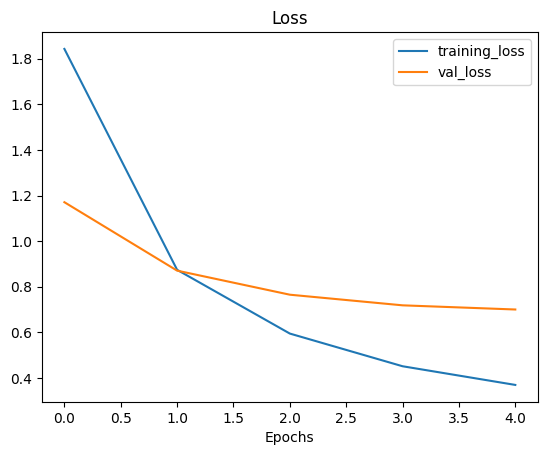

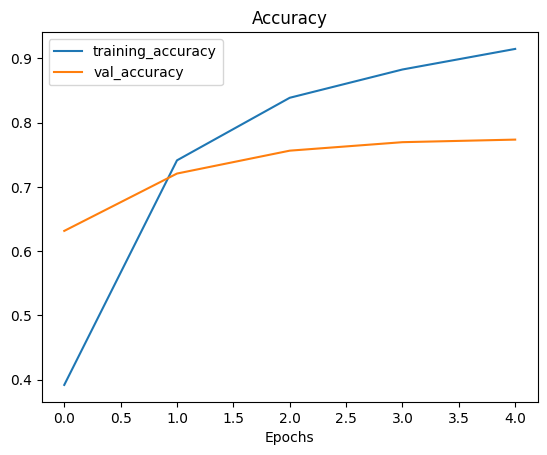

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the `model_url` parameter in the `create_model()` function and the `experiment_name` parameter in the `create_tensorboard_callback()` function.

## Try Another Model

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230916-155320
Epoch 1/5
24/24 [==============================] - 25s 589ms/step - loss: 1.9409 - accuracy: 0.3707 - val_loss: 1.3667 - val_accuracy: 0.7092
Epoch 2/5
24/24 [==============================] - 10s 423ms/step - loss: 1.1063 - accuracy: 0.7707 - val_loss: 0.9027 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 9s 406ms/step - loss: 0.7890 - accuracy: 0.8387 - val_loss: 0.7166 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 12s 535ms/step - loss: 0.6300 - accuracy: 0.8640 - val_loss: 0.6254 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 10s 412ms/step - loss: 0.5298 - accuracy: 0.8867 - val_loss: 0.5678 - val_accuracy: 0.8596


## Analyze the New Model and Its Performance

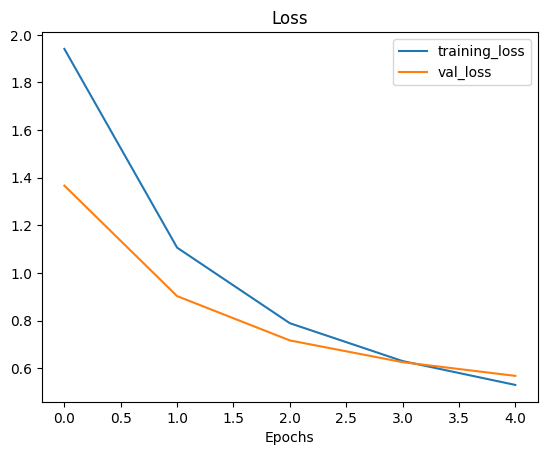

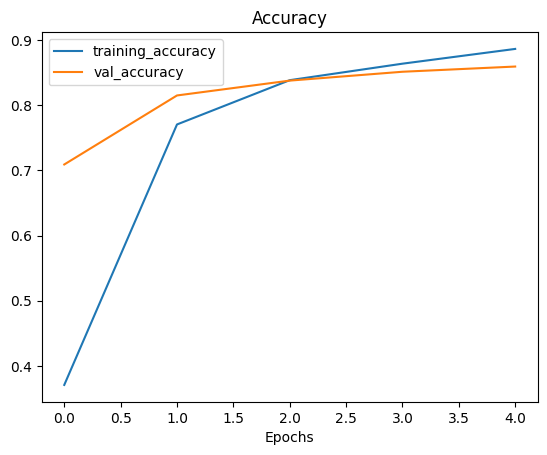

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the  EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

## Compare Performance of Various Models

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-09-16 15:58:55.700408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   HMJ-JLR-KHB



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

In [ ]:
# Check out experiments
!tensorboard dev list # uncomment to see

2023-09-16 16:05:29.366635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/oiR2i4AiRcGafVV3yemCEQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   oiR2i4AiRcGafVV3yemCEQ
	Created              2023-09-16 16:00:44 (4 minutes ago)
	Updated              2023-09-16 16:00:46 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6310046
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id oiR2i4AiRcGafVV3yemCEQ